# 1. Install PIP's

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%pip install keras
%pip install unidecode

In [3]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. Import Packages

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import spacy
import string
import regex as re
from unidecode import unidecode
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from keras.losses import sparse_categorical_crossentropy
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score
from keras.callbacks import EarlyStopping
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

# 3. Load Data

In [ ]:
df = pd.read_parquet("/content/drive/MyDrive/Colab Notebooks/arquivo_mesclado.parquet")
df = df[['reviewText', 'overall']]
df = df.rename(columns={'reviewText': 'clean_text', 'overall': 'category'})

In [ ]:
filtered_df = df.loc[X_test.index]

In [ ]:
filtered_df

,clean_text,category
1507650,Good. The game came in intact and new. Love th...,1.0
854753,am not sure,0.0
570816,it gets tangled so bad I cant even wear it.,-1.0
1023328,Very nice necklace and great buy!,1.0
2390332,Not all of the videos mentioned the connection...,-1.0
...,...,...
1100189,This is a continuation of the myst series. For...,1.0
224162,"After playing Cata for about a month, I gave u...",1.0
2278032,The only reason I gave it one star is because ...,-1.0
1603791,This was a great choice. It came with all my e...,1.0


In [ ]:
filtered_df.to_parquet("/content/drive/MyDrive/Colab Notebooks/filtered_df.parquet")


In [ ]:
df

,clean_text,category
0,This China Silk Black Balaclava is great for k...,1.0
1,This item is very lightweight (as you'd expect...,1.0
2,This item came in only 2 days and in perfect c...,1.0
3,This ring was well worth the price. It has a l...,1.0
4,"It was exactly as described. Beautiful ring, ...",1.0
...,...,...
2662583,My son wanted this game and was so excited to ...,-1.0
2662584,I bought this CD because I am an international...,1.0
2662585,I bought this program and like it. The gentle...,0.0
2662586,I was very dissapointed with this product. It ...,-1.0


# 4. Data Wreangling

### 4.1. Standardize Category

In [ ]:
df['category'] = df['category'].replace({-1: 0, 0: 1, 1: 2})

In [ ]:
df

,clean_text,category
0,This China Silk Black Balaclava is great for k...,2.0
1,This item is very lightweight (as you'd expect...,2.0
2,This item came in only 2 days and in perfect c...,2.0
3,This ring was well worth the price. It has a l...,2.0
4,"It was exactly as described. Beautiful ring, ...",2.0
...,...,...
2662583,My son wanted this game and was so excited to ...,0.0
2662584,I bought this CD because I am an international...,2.0
2662585,I bought this program and like it. The gentle...,1.0
2662586,I was very dissapointed with this product. It ...,0.0


### 4.2. Drop Duplicates and Drop NA

In [ ]:
df = df.drop_duplicates(subset=['clean_text'])

In [ ]:
df = df.dropna(subset=['clean_text'])
df = df.dropna(subset=['category'])

In [ ]:
df['category'] = df['category'].astype(int)

In [ ]:
df

,clean_text,category
0,This China Silk Black Balaclava is great for k...,2
1,This item is very lightweight (as you'd expect...,2
2,This item came in only 2 days and in perfect c...,2
3,This ring was well worth the price. It has a l...,2
4,"It was exactly as described. Beautiful ring, ...",2
...,...,...
2662583,My son wanted this game and was so excited to ...,0
2662584,I bought this CD because I am an international...,2
2662585,I bought this program and like it. The gentle...,1
2662586,I was very dissapointed with this product. It ...,0


# 5. Data Processing

### 5.1. Conversion Column Message in Lower Case

In [ ]:
def to_lower(text):
    return text.lower()

In [ ]:
df['clean_text'] = df['clean_text'].apply(to_lower)

In [ ]:
df

,clean_text,category
0,this china silk black balaclava is great for k...,2
1,this item is very lightweight (as you'd expect...,2
2,this item came in only 2 days and in perfect c...,2
3,this ring was well worth the price. it has a l...,2
4,"it was exactly as described. beautiful ring, ...",2
...,...,...
2662583,my son wanted this game and was so excited to ...,0
2662584,i bought this cd because i am an international...,2
2662585,i bought this program and like it. the gentle...,1
2662586,i was very dissapointed with this product. it ...,0


### 5.2. Removing Punctuation, Exemple (".", "!")

In [ ]:
def remove_punctuation(text):
    punct = string.punctuation
    punct = punct.replace("'", "")  # Removendo as aspas simples
    punct = punct.replace('"', "")  # Removendo as aspas duplas
    translator = str.maketrans('', '', punct)
    return text.translate(translator)

In [ ]:
df['clean_text'] = df['clean_text'].apply(remove_punctuation)

In [ ]:
df

,clean_text,category
0,this china silk black balaclava is great for k...,2
1,this item is very lightweight as you'd expect ...,2
2,this item came in only 2 days and in perfect c...,2
3,this ring was well worth the price it has a lo...,2
4,it was exactly as described beautiful ring pe...,2
...,...,...
2662583,my son wanted this game and was so excited to ...,0
2662584,i bought this cd because i am an international...,2
2662585,i bought this program and like it the gentlem...,1
2662586,i was very dissapointed with this product it i...,0


### 5.3. Removing Emoji

In [ ]:
def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F300-\U0001F5FF"  # simbol and pictogramas
                               u"\U0001F680-\U0001F6FF"  # transport and ]simbol of map
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [ ]:
df['clean_text'] = df['clean_text'].apply(remove_emojis)

In [ ]:
df

,clean_text,category
0,this china silk black balaclava is great for k...,2
1,this item is very lightweight as you'd expect ...,2
2,this item came in only 2 days and in perfect c...,2
3,this ring was well worth the price it has a lo...,2
4,it was exactly as described beautiful ring pe...,2
...,...,...
2662583,my son wanted this game and was so excited to ...,0
2662584,i bought this cd because i am an international...,2
2662585,i bought this program and like it the gentlem...,1
2662586,i was very dissapointed with this product it i...,0


### 5.4. Removing Sites and Blogs

In [ ]:
def remove_urls(text):
    http = r"http\S+|www\.\S+"
    pattern = re.compile(r"({})".format(http))
    return pattern.sub(r'', text)

In [ ]:
df['clean_text'] = df['clean_text'].apply(remove_urls)

In [ ]:
df

,clean_text,category
0,this china silk black balaclava is great for k...,2
1,this item is very lightweight as you'd expect ...,2
2,this item came in only 2 days and in perfect c...,2
3,this ring was well worth the price it has a lo...,2
4,it was exactly as described beautiful ring pe...,2
...,...,...
2662583,my son wanted this game and was so excited to ...,0
2662584,i bought this cd because i am an international...,2
2662585,i bought this program and like it the gentlem...,1
2662586,i was very dissapointed with this product it i...,0


### 5.5. Removing Accentuation

In [ ]:
def remove_accent(text):
    return unidecode(text)

In [ ]:
df['clean_text'] = df['clean_text'].apply(remove_accent)

In [ ]:
df

,clean_text,category
0,this china silk black balaclava is great for k...,2
1,this item is very lightweight as you'd expect ...,2
2,this item came in only 2 days and in perfect c...,2
3,this ring was well worth the price it has a lo...,2
4,it was exactly as described beautiful ring pe...,2
...,...,...
2662583,my son wanted this game and was so excited to ...,0
2662584,i bought this cd because i am an international...,2
2662585,i bought this program and like it the gentlem...,1
2662586,i was very dissapointed with this product it i...,0


### 5.6. Remove Numbers

In [ ]:
def remove_numbers(texto):
    return re.sub(r'\d+', '', texto)

In [ ]:
df['clean_text'] = df['clean_text'].apply(remove_numbers)

In [ ]:
df

,clean_text,category
0,this china silk black balaclava is great for k...,2
1,this item is very lightweight as you'd expect ...,2
2,this item came in only days and in perfect co...,2
3,this ring was well worth the price it has a lo...,2
4,it was exactly as described beautiful ring pe...,2
...,...,...
2662583,my son wanted this game and was so excited to ...,0
2662584,i bought this cd because i am an international...,2
2662585,i bought this program and like it the gentlem...,1
2662586,i was very dissapointed with this product it i...,0


### 5.7. Remove Space Blank Excessive and Remove Broke Line

In [ ]:
def remove_broke_line(texto):
    return texto.replace('\n', ' ')

In [ ]:
df['clean_text'] = df['clean_text'].apply(remove_broke_line)

In [ ]:
df

,clean_text,category
0,this china silk black balaclava is great for k...,2
1,this item is very lightweight as you'd expect ...,2
2,this item came in only days and in perfect co...,2
3,this ring was well worth the price it has a lo...,2
4,it was exactly as described beautiful ring pe...,2
...,...,...
2662583,my son wanted this game and was so excited to ...,0
2662584,i bought this cd because i am an international...,2
2662585,i bought this program and like it the gentlem...,1
2662586,i was very dissapointed with this product it i...,0


In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag

# Certifique-se de baixar o tokenizador punkt do NLTK
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
def tokenize_text(text):
    words = word_tokenize(text)
    tagged_words = pos_tag(words)
    allowed_pos = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ',   # Verbos
                   'NN', 'NNS', 'NNP', 'NNPS',               # Substantivos
                   'JJ', 'JJR', 'JJS',                       # Adjetivos
                   'RB', 'RBR', 'RBS']                       # Advérbios
    filtered_words = [word for word, pos in tagged_words if pos in allowed_pos]
    filtered_text = ' '.join(filtered_words)
    return filtered_text

In [ ]:
# Aplicar a função de tokenização ao DataFrame
df['clean_text'] = df['clean_text'].apply(tokenize_text)

### 5.8. Remove Blank Space Text

In [ ]:
def strip_text(text):
    return text.strip()

In [ ]:
df['clean_text'] = df['clean_text'].apply(strip_text)

In [ ]:
df

,clean_text,category
0,china silk black balaclava is great keeping wa...,2
1,item is very lightweight expect silk underwear...,2
2,item came only days perfect condition is very ...,2
3,ring was well price has lovely shine fits true...,2
4,was exactly described beautiful ring perfect f...,2
...,...,...
2662583,son wanted game was so excited buy own money d...,0
2662584,i bought cd i am international student i very ...,2
2662585,i bought program gentleman had said was greatl...,1
2662586,i was very dissapointed product is not much ni...,0


### 5.9. Drop NA

In [ ]:
df = df.dropna(subset=['clean_text'])

In [5]:
df = pd.read_parquet("/content/drive/MyDrive/Colab Notebooks/arquivo_tratado2.parquet")

In [6]:
df

,clean_text,category
2519749,i purchased high hopes shirt is nice just real...,2
1596244,want something fancy wow friends do caution wa...,0
1888744,great game so much fun,2
1199080,i 've never bought joystick i started playing ...,2
797418,pictures show white trim came black false adve...,0
...,...,...
2074331,peices mostly did not look right length still ...,1
1394664,almost impossible play computer controller,0
429049,way too sized button front detail was torn mis...,0
1479114,great controller issues,2


# 6. Previus Analyze

In [ ]:
def df_metadata(df):
    metadata = pd.DataFrame(df.dtypes, columns=['dtypes'])
    metadata = metadata.reset_index()
    metadata['Column'] = metadata['index']
    metadata = metadata[['Column', 'dtypes']]
    metadata['# Missing'] = df.isnull().sum().values
    metadata['# Unique'] = df.nunique().values

    # Verificar se o DataFrame não está vazio
    if not df.empty:
        metadata['Example'] = df.iloc[0].values
    else:
        metadata['Example'] = None

    return metadata

# Aplicar a função ao DataFrame
df_metadata(df)

,Column,dtypes,# Missing,# Unique,Example
0,clean_text,object,0,2364976,this china silk black balaclava is great for k...
1,category,int32,0,3,2


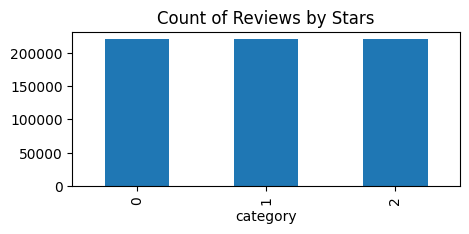

In [104]:
ax = df['category'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(5,2))

In [ ]:
example = df['clean_text'].iloc[1]
print(example)

want something fancy wow friends do caution want batteries hold charge look somewhere else rc batteries are worst i 've ever had ever recharging is almost waste time almost better using regular walmart brand batteries lol


In [7]:
# Contar o número de cada categoria
counts = df['category'].value_counts()

# Mostrar os resultados
print("Número de ocorrências para cada categoria:")
print("Categoria 0:", counts.get(0, 0))
print("Categoria 1:", counts.get(1, 0))
print("Categoria 2:", counts.get(2, 0))

Número de ocorrências para cada categoria:
Categoria 0: 220269
Categoria 1: 220269
Categoria 2: 220269


In [ ]:
min_count = counts.min()

df = pd.concat([
    df[df['category'] == category].sample(min_count, replace=False)
    for category in counts.index
])

df = df.sample(frac=1, random_state=42)

print("Número de ocorrências para cada categoria após subamostragem:")
print(df['category'].value_counts())


Número de ocorrências para cada categoria após subamostragem:
category
2    220269
0    220269
1    220269
Name: count, dtype: int64


# 7. Training Model Sequential with LSTM

### 7.1. Splitting Dataframe into X and Y

In [8]:
X = df['clean_text']
y = df['category']

### 7.2. Split Between Training and Testing

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

In [ ]:
X_test

1507650                  good game came intact new love game
854753                                           am not sure
570816                  gets tangled so bad i cant even wear
1023328                         very nice necklace great buy
2390332    not videos mentioned connection career math vi...
                                 ...                        
1100189    is continuation myst series are best i hope ar...
224162     playing cata month i gave i did n't like did t...
2278032    only reason i gave star is i n't figure give s...
1603791    was great choice came expectations more i got ...
629079     i 'm was too short legs too big upper body che...
Name: clean_text, Length: 132162, dtype: object

In [ ]:
X_test.to_parquet("/content/drive/MyDrive/Colab Notebooks/amazon_review_test.parquet")

AttributeError: 'Series' object has no attribute 'to_parquet'

### 7.3. Tokenizer Dataframe X

In [31]:
num_words = 2048
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

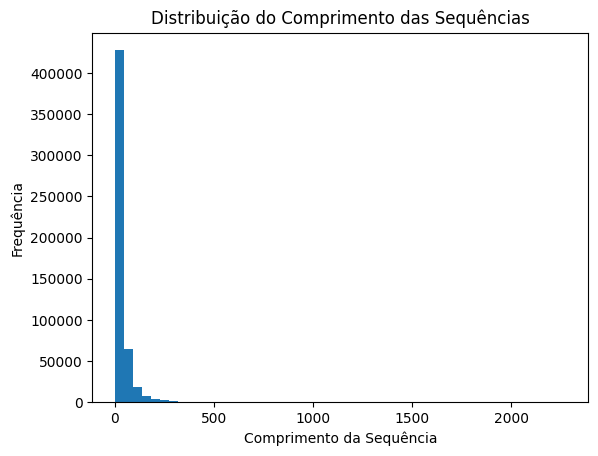

O comprimento que cobre 90% das sequências é: 72.0


In [16]:
sequence_lengths = [len(seq) for seq in train_sequences]

plt.hist(sequence_lengths, bins=50)
plt.xlabel('Comprimento da Sequência')
plt.ylabel('Frequência')
plt.title('Distribuição do Comprimento das Sequências')
plt.show()

percentil_90 = np.percentile(sequence_lengths, 90)
print(f"O comprimento que cobre 90% das sequências é: {percentil_90}")

max_length = int(percentil_90)

### 7.4. Convert em Pad Sequences

In [17]:
train_padded = pad_sequences(train_sequences, maxlen=max_length)
test_padded = pad_sequences(test_sequences, maxlen=max_length)

### 7.5. Make Model With LSTM

In [19]:
vocab_size = len(tokenizer.word_index) + 1

In [39]:
from tensorflow.keras.layers import Bidirectional

# Make Model
model = Sequential()

# Corrected Embedding layer
model.add(Embedding(input_dim=vocab_size, output_dim=256, input_length=max_length))
model.add(Dropout(0.2))
# Add Bidirectional LSTM layers with dropout for regularization
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))

# Add Dense layers
model.add(Dense(3, activation='softmax'))

# Compile
model.compile(optimizer='adam', loss=sparse_categorical_crossentropy, metrics=['accuracy'])
model.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 72, 256)           63927296  
                                                                 
 dropout (Dropout)           (None, 72, 256)           0         
                                                                 
 lstm_10 (LSTM)              (None, 72, 128)           197120    
                                                                 
 dropout_1 (Dropout)         (None, 72, 128)           0         
                                                                 
 lstm_11 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 3)                

In [21]:
class_weights = dict(enumerate(1. / df['category'].value_counts(normalize=True)))
print(class_weights)

{0: 3.0, 1: 3.0, 2: 3.0}


In [41]:
# Definir o EarlyStopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)

# Treinar o modelo com EarlyStopping e pesos das classes
history = model.fit(train_padded, y_train, batch_size=64,
                    validation_split=0.2, callbacks=[early_stopping], epochs=1000)

Epoch 1/1000
6609/6609 [==============================] - 207s 31ms/step - loss: 0.6766 - accuracy: 0.6998 - val_loss: 0.6442 - val_accuracy: 0.7178
Epoch 2/1000
6609/6609 [==============================] - 169s 26ms/step - loss: 0.6227 - accuracy: 0.7282 - val_loss: 0.6200 - val_accuracy: 0.7298
Epoch 3/1000
6609/6609 [==============================] - 171s 26ms/step - loss: 0.5983 - accuracy: 0.7407 - val_loss: 0.6126 - val_accuracy: 0.7331
Epoch 4/1000
6609/6609 [==============================] - 170s 26ms/step - loss: 0.5791 - accuracy: 0.7492 - val_loss: 0.6077 - val_accuracy: 0.7360
Epoch 5/1000
6609/6609 [==============================] - 169s 26ms/step - loss: 0.5600 - accuracy: 0.7586 - val_loss: 0.6145 - val_accuracy: 0.7343
Epoch 6/1000
6609/6609 [==============================] - 169s 26ms/step - loss: 0.5422 - accuracy: 0.7673 - val_loss: 0.6174 - val_accuracy: 0.7345
Epoch 7/1000
6609/6609 [==============================] - 168s 25ms/step - loss: 0.5263 - accuracy: 0.7747

### 7.6. Test Accuracy

In [ ]:
# Avaliar o modelo no conjunto de teste
loss, accuracy = model.evaluate(test_padded, y_test)

# Imprimir a acurácia
print("Accuracy:", accuracy)

4131/4131 [==============================] - 23s 6ms/step - loss: 0.6589 - accuracy: 0.7233
Accuracy: 0.7232562899589539


In [42]:
from sklearn.metrics import classification_report

predictions = model.predict(test_padded)
predicted_labels = np.argmax(predictions, axis=1)
report = classification_report(y_test, predicted_labels, target_names=['Negativo', 'Neutro', 'Positivo'])
print(report)

4131/4131 [==============================] - 22s 5ms/step
              precision    recall  f1-score   support

    Negativo       0.76      0.76      0.76     43905
      Neutro       0.65      0.62      0.63     43910
    Positivo       0.80      0.83      0.81     44347

    accuracy                           0.74    132162
   macro avg       0.73      0.74      0.73    132162
weighted avg       0.73      0.74      0.74    132162



### 7.7. Saving Models

In [46]:
model.save("/content/drive/MyDrive/Colab Notebooks/kerasmodelLSTMEquals32New.h5")
model.save("/content/drive/MyDrive/Colab Notebooks/kerasmodelLSTMEquals32New.keras")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### 7.8. Tests Out Dataframe Train/Test

In [44]:
# Frases sobre produtos em inglês
negative_text = "bad"
neutral_text = "This product has basic features that meet day-to-day needs."
positive_text = "I am impressed with the quality of this product; it has exceeded my expectations in every aspect."

# Lista de frases
product_texts = [negative_text, neutral_text, positive_text]

# Tokenização das frases
tokenized_texts = tokenizer.texts_to_sequences(product_texts)

# Preenchimento das sequências
padded_texts = pad_sequences(tokenized_texts, maxlen=max_length)

sentiments = ['Negativo', 'Neutro', 'Positivo']


# Prever o sentimento de cada frase
for i, padded_text in enumerate(padded_texts):
    predictions = model.predict(np.array([padded_text]))
    predicted_sentiment = sentiments[np.argmax(predictions)]
    print("Frase:", product_texts[i])
    print("Sentimento Previsto:", predicted_sentiment)
    print()

1/1 [==============================] - 0s 33ms/step
Frase: bad
Sentimento Previsto: Negativo

1/1 [==============================] - 0s 38ms/step
Frase: This product has basic features that meet day-to-day needs.
Sentimento Previsto: Neutro

1/1 [==============================] - 0s 131ms/step
Frase: I am impressed with the quality of this product; it has exceeded my expectations in every aspect.
Sentimento Previsto: Positivo



### 7.9. Confusion Matrix

4131/4131 [==============================] - 18s 4ms/step


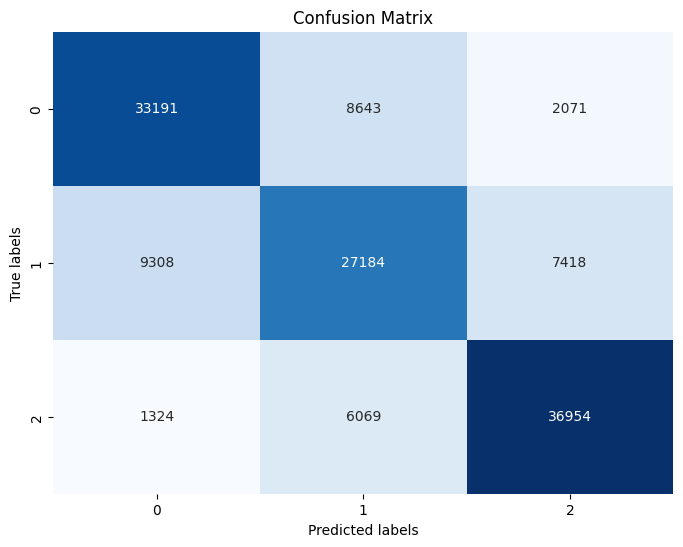

In [45]:
# Fazer previsões nos dados de teste
y_pred = model.predict(test_padded)

# Obter as classes previstas convertendo as probabilidades em rótulos
y_pred_labels = np.argmax(y_pred, axis=1)

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred_labels)

# Visualizar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### 7.10. Loss and Accuracy

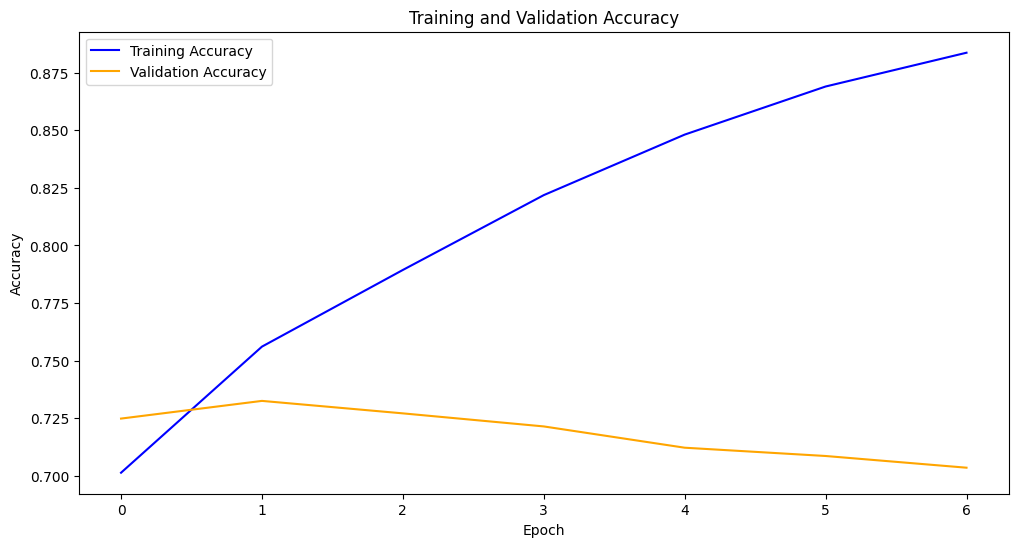

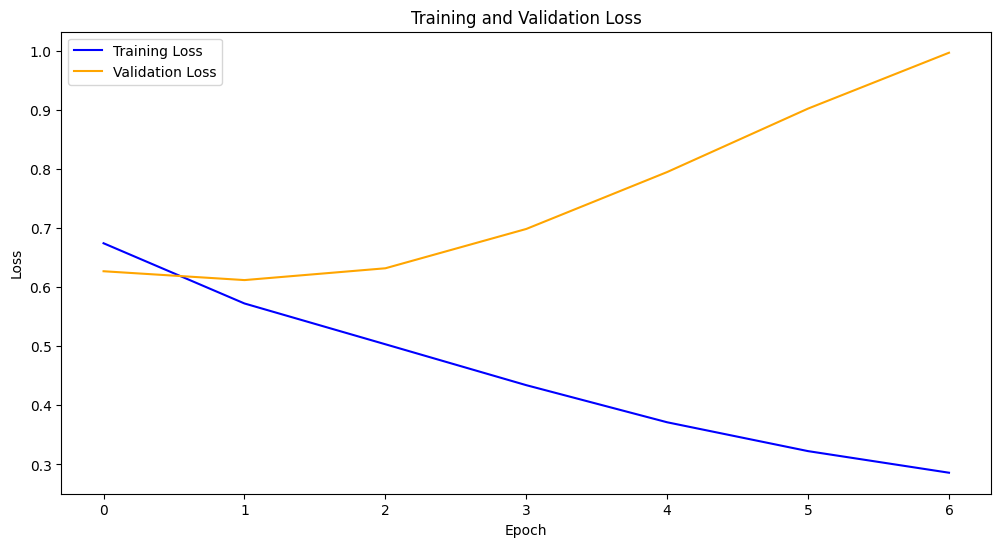

In [119]:
# Extrair acurácia e perda do histórico
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotar acurácia
plt.figure(figsize=(12, 6))
plt.plot(accuracy, label='Training Accuracy', color='blue')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotar perda
plt.figure(figsize=(12, 6))
plt.plot(loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()